In [3]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import tensorflow as tf

2022-06-14 22:44:48.114012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 22:44:48.114051: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Helper function(s)
Here are some helper function for:

* Drawing neural network diagrams
* Plotting learned decision boundaries

In [4]:
def draw_neural_net(ax, layer_sizes, coefs_, intercepts_,
                    left=0.1, right=.9, bottom=0.1, top=.9):
    '''
    Draw a neural network cartoon using matplotilb.
    Adapted: https://gist.github.com/craffel/2d727968c3aaebd10359
    
    Args:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw=1, head_width=0.01, head_length=0.02)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color='w', ec='k', zorder=4)
            if n == 0:
                plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m+1)+'}$', fontsize=15)
            elif (n_layers == 3) & (n == 1):
                plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m+1)+'}$', fontsize=15)
            elif n == n_layers -1:
                plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m+1)+'}$', fontsize=15)
            ax.add_artist(circle)
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8., color='w', ec='k', zorder=4)
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing-0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.1)*np.sin(rot_mo_rad) + .01
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                plt.text(xm1, ym1,
                         str(round(coefs_[n][m, o],2)),
                         rotation = rot_mo_deg,
                         fontsize = 10)
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        x_bias = (n+0.5)*h_spacing + left
        y_bias = top + 0.005 
        for o in range(layer_size_b):
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c='k')
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.08 * np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 * np.sin(rot_bo_rad)
            plt.text(xo1, yo1,
                 str(round(intercepts_[n][o],2)),
                 rotation = rot_bo_deg,
                 fontsize = 10)    
                
    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)

In [5]:
def plot_decision_boundary(X, Y, model, steps=100, size=3, cmap='bwr'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    cmap = plt.get_cmap(cmap)
    
    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.3)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, s=size)
    
    return fig, ax

In [6]:
def generate_spiral_data(num=1000):
  np.random.seed(1)
  X = []
  
  # The delta values correspond to different offsets for the 2 classes.
  for delta in [0, np.pi]:
    for i in range(num):
      r = 1.0 * i / num * 5
      t = 1.75 * i / num * 2 * np.pi + delta
      x0 = r * np.sin(t) + (2 * np.random.rand() - 1) * 0.1
      x1 = r * np.cos(t) + (2 * np.random.rand() - 1) * 0.1
      X.append([x0, x1])
      
  X = np.array(X)
  Y = np.concatenate([np.zeros(num), np.ones(num)]).astype(int)

  shuf_idx = np.random.permutation(len(Y))
  X = X[shuf_idx]
  Y = Y[shuf_idx]

  return X, Y

## The XOR Problem

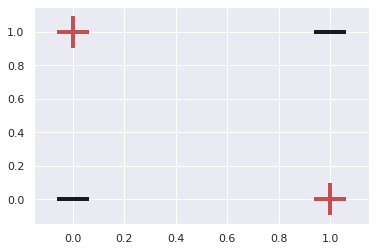

In [7]:
# Define XOR data.
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 0])

# Plot XOR data.
pos_X = X[Y==1]
neg_X = X[Y==0]
plt.scatter(x=pos_X[:,0], y=pos_X[:,1], marker='+', c='r', s=1000, linewidth=4)
plt.scatter(x=neg_X[:,0], y=neg_X[:,1], marker='_', c='k', s=1000, linewidth=4)
plt.xlim(-0.15, 1.15)
plt.ylim(-0.15, 1.15)
plt.show()

In [8]:
print(X.shape)

(4, 2)


### Linear Models

In [ ]:
def build_linear_xor_model():
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()

  # Set input shape in advance
  model.add(tf.keras.Input(shape=(2,), name='Input'))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))
  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1))
  return model

In [ ]:
# Build the model and show a summary.
xor_model = build_linear_xor_model()
print(xor_model.summary())

# Train a model and show loss
history = xor_model.fit(
    x=X,
    y=Y,
    epochs=100,
    batch_size=4,
    verbose=0)
losses = history.history['loss']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Cross-Entropy Loss')
plt.show()

# Show data and predictions
preds = xor_model.predict(X)
for i in range(len(Y)):
  (x1,x2) = X[i]
  y = Y[i]
  y_hat = preds[i]
  print("x [%d %d]  y [%d]  ŷ [%.4f]" %(x1, x2, y, y_hat))

# Show learned model
w, b = xor_model.layers[0].get_weights()
print('f(x) = sigmoid(%.4f + %.4f*x1 + %.4f*x2)' %(b[0], w[0], w[1]))

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, [2, 1], {0:w}, {0:b})

### Neural Network Models

In [ ]:
def build_ffnn_xor_model(hidden_layer_sizes=[]):
  tf.keras.backend.clear_session()
  tf.random.set_seed(1)

  model = tf.keras.Sequential()
  # Set input shape in advance
  model.add(tf.keras.Input(shape=(2,), name='Input'))
  for hidden_layer_size in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation='relu',
                                    name='Hidden'))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))
  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1))
  return model

In [ ]:
# Build the model and show a summary.
xor_model = build_ffnn_xor_model(hidden_layer_sizes=[2])
print(xor_model.summary())

# Train a model and show loss
history = xor_model.fit(
    x = X,
    y = Y,
    epochs=2000,
    batch_size=4,
    verbose=0)
losses = history.history['loss']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Cross-Entropy Loss')
plt.show()

# Show data and predictions
preds = xor_model.predict(X)
for i in range(len(Y)):
  (x1,x2) = X[i]
  y = Y[i]
  y_hat = preds[i]
  print("x [%d %d]  y [%d]  ŷ [%.4f]" %(x1, x2, y, y_hat))

# Get model weights
w0, b0 = xor_model.layers[0].get_weights()
w1, b1 = xor_model.layers[1].get_weights()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, [2, 2, 1], {0:w0, 1:w1}, {0:b0, 1:b1})

### Forward Pass Prediction

Use the learned weights shown in the model diagram to fill in the intermediate values $h_1$ and $h_2$ and the final predictions $\hat{y}$. Remember to use the right *activation* functions.

$x_1$ | $x_2$ | $h_1$ | $h_2$ | $\hat{y}$ | $y$
-|-|-|-|-|-
0|0|
0|1|
1|0|
1|1|

### Decision Boundary

Use the helper function to draw the decision boundary learned by the XOR model.

In [ ]:
plot_decision_boundary(X, Y, xor_model, size=30)
plt.show()

## The Spiral Problem

In [ ]:
X, Y = generate_spiral_data(1000)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr', s=3)
plt.show()

In [ ]:
def build_spiral_model(hidden_layer_sizes=[], seed=0):
  tf.keras.backend.clear_session()
  tf.random.set_seed(seed)

  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(2,), name='Input'))
  for hidden_layer_size in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation='relu'))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))
  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=.03))
  return model

### Neural Network Models

In [ ]:
layer_sizes = [8, 8, 4, 4]
spiral_model = build_spiral_model(hidden_layer_sizes=layer_sizes)
print(spiral_model.summary())

history = spiral_model.fit(
    x=X, y=Y, epochs=100, batch_size=16, verbose=0)
losses = history.history['loss']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Cross-Entropy Loss')
label = '{:.2f}'.format(losses[-1])
plt.annotate(label, (len(losses), losses[-1]))
plt.show()

In [ ]:
weights_as_dict = {}
biases_as_dict = {}
for i in range(len(layer_sizes) + 1):
  w, b = spiral_model.layers[i].get_weights()
  weights_as_dict[i] = w
  biases_as_dict[i] = b

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, [2]+layer_sizes+[1], weights_as_dict, biases_as_dict)

### Decision Boundary

In [ ]:
plot_decision_boundary(X, Y, spiral_model, size=3)
plt.show()